# Laboratorio 1: Conceptos básicos de aprendizaje automático

En este laboratorio les tocará probar con distintos parámetros de los algoritmos de aprendizaje automático aprendidos hasta ahora. La idea es que vean como la selección de atributos, el cambio de hiperparámetros, y los distintos algoritmos afectan los resultados de un regresor o clasificador sobre un conjunto de datos.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_boston, load_breast_cancer, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

from ml.visualization import plot_confusion_matrix, classifier_boundary

np.random.seed(1234)  # Setup seed to be more deterministic

%matplotlib inline

## Regresión

### Carga de datos

In [4]:
boston_data = load_boston()

# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
shuff_data = np.random.permutation(506)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = boston_data['data'][shuff_train]
X_val = boston_data['data'][shuff_val]

y_train = boston_data['target'][shuff_train]
y_val = boston_data['target'][shuff_val]

# Necesario para poder hacer un regresor por feature
feature_map = {feature: idx for idx, feature in enumerate(boston_data['feature_names'])}

print(boston_data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Regresión sin regularización

Para revisar cómo afecta el cambio de parámetros y los distintos tipos de regresores y atributos (características) al resultado final del algoritmo de aprendizaje automático, lo que se va a hacer es entrenar el regresor tomando sólo un atributo y visualizar eso.

Se busca entrenar utilizando el conjunto de entrenamiento (el terminado en `train`) y evaluar utilizando el conjunto de validación (el terminado en `val`). Luego se visualiza la función calculada para cada conjunto y se la compara.

Los atributos posibles están listados en la descripción del conjunto de datos en la celda anterior. No todos son útiles para visualizar, en particular solo nos interesan los atributos numéricos y descartamos los atributos que se listan a continuación:

- `CHAS`: Atributo categórico (toma valor 0 o 1).
- `RAD`: Atributo categórico (índice).
- `MEDV`: Este valor se lo lista como atributo en la descripción del conjunto de datos pero en realidad es el valor de `y`, i.e. es el valor que tratamos de aproximar con el algoritmo de aprendizaje automático.

In [51]:
# Seleccionamos un atributo de los listados en la descripción que no sea categórico
selected_feature = 'LSTAT'  # TODO: modificar esto por algún otro valor para ver como cambian los resultados
feature_col = feature_map[selected_feature]
X_train_feature = X_train[:, feature_col].reshape(-1, 1)  # Hay que ser que sea una matriz no un vector para que funcione con scikit learn
X_val_feature = X_val[:, feature_col].reshape(-1, 1)

### Regresión lineal

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [52]:
# Entrenamos un clasificador utilizando sólo ese atributo sobre el conjunto de entrenamiento (X_train, y_train)
model = LinearRegression()
model.fit(X_train_feature, y_train)

# Evaluamos el desempeño del clasificador utilizando la media del error cuadrado (MSE o mean squared error)
# sobre el conjunto de datos de entrenamiento (X_train, y_train) y lo comparamos con el de validación (X_val, y_val)
# Mientras más cercano a cero mejor
print('Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train, model.predict(X_train_feature)))
print('Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_val, model.predict(X_val_feature)))

Media del error cuadrado para entrenamiento: 36.54
Media del error cuadrado para validación: 45.90


**Interpretacion del cambio de *selected_feature***

Dependiendo de que feature se elija para entrenar el modelo de regresion lineal se ve mucha diferencia entre la media del error cuadrado, tanto para el entrenamiento como para la validacion. En el caso de la feature seleccionado "LSTAT", se notó un gran decremento en la media del error cuadrado.

##### Visualización de la regresión lineal

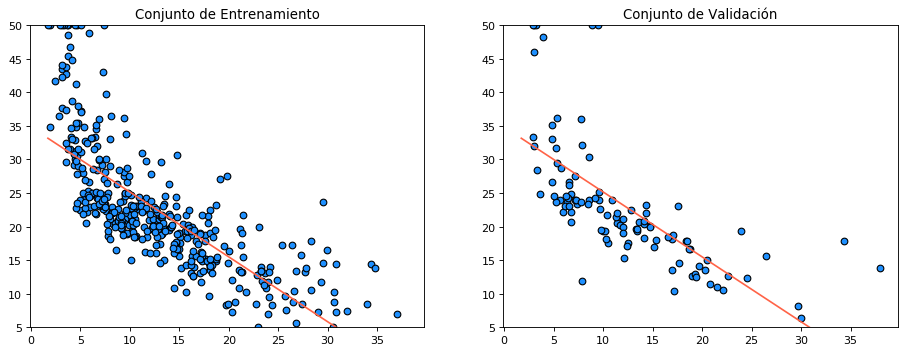

In [54]:
plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')

X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
y_range_start = np.min(np.r_[y_train, y_val])
y_range_stop = np.max(np.r_[y_train, y_val])
X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(X_train_feature, y_train, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Validación")

plt.show()

### Regresión polinomial

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [55]:
polynomial_degree = 4 # TODO: Probar distintos grados del polinomio

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_feature)
X_poly_train = poly_features.transform(X_train_feature)
X_poly_val = poly_features.transform(X_val_feature)

model = LinearRegression()
model.fit(X_poly_train, y_train)

print('Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train, model.predict(X_poly_train)))
print('Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_val, model.predict(X_poly_val)))

Media del error cuadrado para entrenamiento: 25.55
Media del error cuadrado para validación: 35.51


##### Visualización de la regresión polinomial

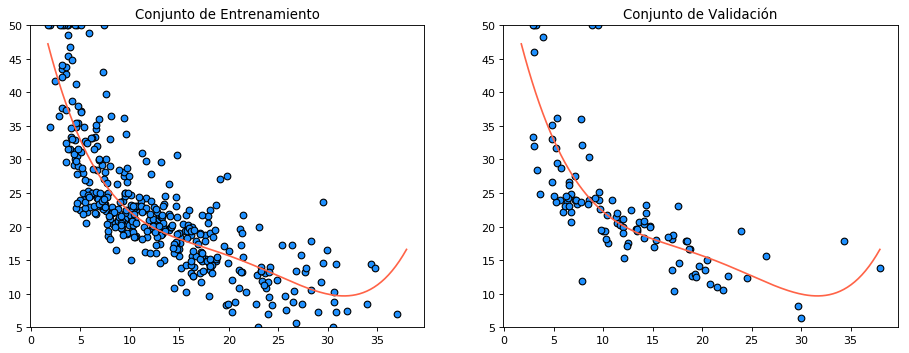

In [56]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
y_range_start = np.min(np.r_[y_train, y_val])
y_range_stop = np.max(np.r_[y_train, y_val])
X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)
X_linspace_poly = poly_features.transform(X_linspace)

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(X_train_feature, y_train, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Validación")

plt.show()

**Interpretacion del cambio de grado del polinomio**

Se probaron con grados del 1 al 6, seleccionando el 4to grado como el mas optimo a simple vista.

Del 1 al 3 inclusive se veian mejoras en el MSE (aka iba disminuyendo), pero se podia facilmente identificar un caso de underfitting. Sin embargo al llegar al 5to grado se vio un comportamiento errático en los extremos de los datos de validacion (overfitting de los datos de train). Al llegar al grado 6 este error fue aun mas grave por lo que se decidio seleccionar el 4to grado como el más optimo ya que se consigue un equilibrio en el MSE tanto de train como de validacion.

### Regresión lineal con regularización

- https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [68]:
alpha = 1 # TODO: Parámetro de regularización. También denominado como parámetro `lambda`.

model = Ridge(alpha=alpha)
model.fit(X_train_feature, y_train)

print('Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train, model.predict(X_train_feature)))
print('Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_val, model.predict(X_val_feature)))

Media del error cuadrado para entrenamiento: 36.54
Media del error cuadrado para validación: 45.90


##### Visualización de la regresión lineal

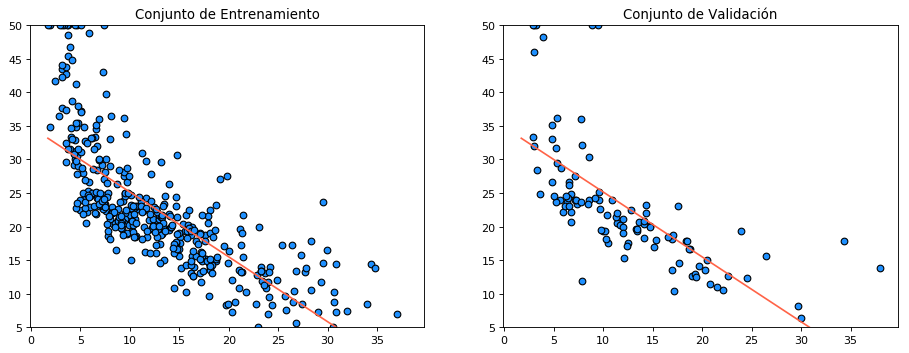

In [69]:
plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')

X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
y_range_start = np.min(np.r_[y_train, y_val])
y_range_stop = np.max(np.r_[y_train, y_val])
X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(X_train_feature, y_train, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Validación")

plt.show()

**Interpretacion parametro *alpha* (lambda)**

No tiene sentido modificar el valor de alpha en un modelo de regresion lineal ya que éste afecta a los factores de mayor orden (disminuyendo su impacto) en el caso que el modelo se polinomial.

### Regresión polinomial con regularización

In [138]:
polynomial_degree = 10 # TODO: Grado del polinomio.
alpha1 = 0 # TODO: Parámetro de regularización. También denominado como parámetro `lambda`.
alpha2 = 1
poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_feature)
X_poly_train = poly_features.transform(X_train_feature)
X_poly_val = poly_features.transform(X_val_feature)

model1 = Ridge(alpha=alpha1)
model1.fit(X_poly_train, y_train)

print('(model1) Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train, model1.predict(X_poly_train)))
print('(model1) Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_val, model1.predict(X_poly_val)))


model2 = Ridge(alpha=alpha2)
model2.fit(X_poly_train, y_train)

print('(model2) Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train, model2.predict(X_poly_train)))
print('(model2) Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_val, model2.predict(X_poly_val)))

(model1) Media del error cuadrado para entrenamiento: 32.38
(model1) Media del error cuadrado para validación: 37.82
(model2) Media del error cuadrado para entrenamiento: 24.68
(model2) Media del error cuadrado para validación: 35.36


/home/gian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.80026e-32): result may not be accurate.
  overwrite_a=True).T


##### Visualización de la regresión polinomial

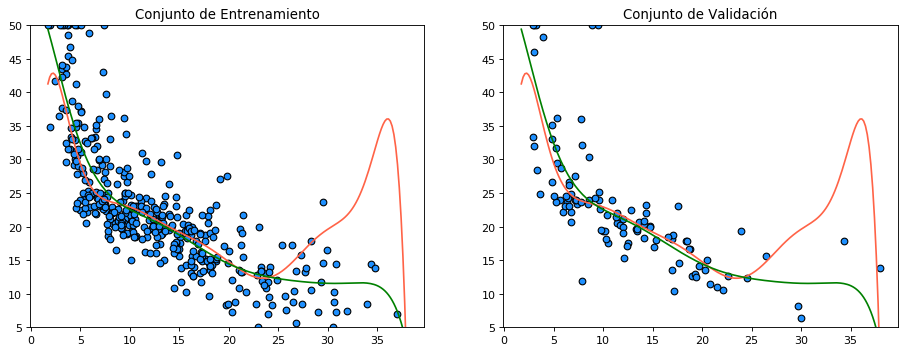

In [140]:
plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')

X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
y_range_start = np.min(np.r_[y_train, y_val])
y_range_stop = np.max(np.r_[y_train, y_val])
X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)
X_linspace_poly = poly_features.transform(X_linspace)

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(X_train_feature, y_train, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model1.predict(X_linspace_poly), color="tomato", label="modelo")
plt.plot(X_linspace, model2.predict(X_linspace_poly), color="green", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model1.predict(X_linspace_poly), color="tomato", label="modelo")
plt.plot(X_linspace, model2.predict(X_linspace_poly), color="green", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Validación")

plt.show()

**Interpretacion parametro alpha (lambda)**

Para regresion polinomial vemos contrariaemnte a regresion lineal que si hay un cambio notorio al modifical el valor de alpha. Se selecciono un grado de polinomio alto a proposito a que sea mas claro como afecta lamba a los sumandos de alto orden de la funcion de modelado.

Vemos en rojo el modelo sin regularizar (alpha=0) y en verde el modelo compensado. En este ultimo se ve como se soluciona el overfitting generado por elegir un polinio de grado groseramente elevado

## Clasificación binaria

La clasificación binaria tiene dos posibles etiquetas para su clasificación: SI y NO (o 0 y 1, o -1 y 1). Nuevamente, se busca entrenar utilizando el conjunto de entrenamiento (el terminado en `train`) y evaluar utilizando el conjunto de validación (el terminado en `val`). Luego se visualiza la función calculada para cada conjunto y se la compara.

Similar al caso anterior, para poder visualizar los distintos atributos y cómo estos afectan el modelo, debemos hacer uso de una selección de atributos a mano. En este caso todos los atributos son válidos, puesto que todos son numéricos. Como tenemos una clasificación, lo que buscamos ver es la frontera de decisión eligiendo distintos atributos y parámetros para distintos clasificadores. En este caso elegimos 2 atributos ya que la clase se representará por color dentro del gráfico.

### Carga de datos

In [ ]:
breast_cancer_data = load_breast_cancer()

# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
shuff_data = np.random.permutation(569)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = breast_cancer_data['data'][shuff_train]
X_val = breast_cancer_data['data'][shuff_val]

y_train = breast_cancer_data['target'][shuff_train]
y_val = breast_cancer_data['target'][shuff_val]

feature_map = {feature: idx for idx, feature in enumerate(breast_cancer_data['feature_names'])}

print(breast_cancer_data['DESCR'])

In [ ]:
print("Listado de atributos\n====================")
for feature in breast_cancer_data['feature_names']:
    print("- %s" % feature)

In [ ]:
# Seleccionamos dos atributo de los listados en el apartado anterior, uno para el eje x y otro para el eje y
# TODO: cambiar con estos features
x_feature = 'mean radius'
y_feature = 'mean texture'

x_feature_col = feature_map[x_feature]
y_feature_col = feature_map[y_feature]
X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

### Perceptrón

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html

In [ ]:
penalty = # TODO: Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
alpha = # TODO: Parámetro de regularización. También denominado como parámetro `lambda`.
max_iter = # TODO: Cantidad máxima de iteraciones del algoritmo

model = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter)
model.fit(X_train_feature, y_train)

# Evaluamos el desempeño del clasificador utilizando la exactitud (accuracy) sobre el conjunto
# de datos de entrenamiento (X_train, y_train) y lo comparamos con el de validación (X_val, y_val)
# La exactitud toma valor en el rango [0, 1] donde más alto es mejor
print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

#### Matriz de confusión

La matriz de confusión sirve en clasificación para ver que tanto se desviaron las instancias (de entrenamiento o de validación) de su valor real.

In [ ]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=breast_cancer_data.target_names,
                      title='Matriz de confusión para entrenamiento (sin normalizar)')
plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=breast_cancer_data.target_names, normalize=True,
                      title='Matriz de confusión para entrenamiento (normalizando)')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=breast_cancer_data.target_names,
                      title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=breast_cancer_data.target_names, normalize=True,
                      title='Matriz de confusión para validación (normalizando)')

plt.show()

#### Visualización de la frontera de decisión

In [ ]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)

cmap_dots = ListedColormap(['tomato', 'dodgerblue'])
cmap_back = ListedColormap(['lightcoral', 'skyblue'])

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_val_feature[:, 0], X_val_feature[:, 1], c=y_val, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Validación")

plt.show()

### Regresión logística

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
penalty =  # TODO: Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
alpha =  # TODO: Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.

model = LogisticRegression(penalty=penalty, C=1./alpha)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

#### Matriz de confusión

In [ ]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=breast_cancer_data.target_names,
                      title='Matriz de confusión para entrenamiento (sin normalizar)')
plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=breast_cancer_data.target_names, normalize=True,
                      title='Matriz de confusión para entrenamiento (normalizando)')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=breast_cancer_data.target_names,
                      title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=breast_cancer_data.target_names, normalize=True,
                      title='Matriz de confusión para validación (normalizando)')

plt.show()

#### Visualización de la frontera de decisión

In [ ]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)

cmap_dots = ListedColormap(['tomato', 'dodgerblue'])
cmap_back = ListedColormap(['lightcoral', 'skyblue'])

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_val_feature[:, 0], X_val_feature[:, 1], c=y_val, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Validación")

plt.show()

### Vecinos más cercanos

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
n_neighbors = # TODO: Cantidad de vecinos a tener en cuenta
metric =  # TODO: Medida de distancia. Algunas opciones: cosine, euclidean, manhattan.

model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

#### Matriz de confusión

In [ ]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=breast_cancer_data.target_names,
                      title='Matriz de confusión para entrenamiento (sin normalizar)')
plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=breast_cancer_data.target_names, normalize=True,
                      title='Matriz de confusión para entrenamiento (normalizando)')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=breast_cancer_data.target_names,
                      title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=breast_cancer_data.target_names, normalize=True,
                      title='Matriz de confusión para validación (normalizando)')

plt.show()

#### Visualización de la frontera de decisión

In [ ]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)

cmap_dots = ListedColormap(['tomato', 'dodgerblue'])
cmap_back = ListedColormap(['lightcoral', 'skyblue'])

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_val_feature[:, 0], X_val_feature[:, 1], c=y_val, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Validación")

plt.show()

## Clasificación multiclase

Ahora veremos clasificación multiclase. Muy similar al caso anterior, con la diferencia de que en este caso hay más de dos etiquetas posibles para clasificación. Se utilizará el método `one-vs-all` (o también `one-vs-rest`) para hacer posible la clasificaicón.

Una vez más tenemos que decidir dos features para poder visualizar los modelos.

### Carga de datos

In [ ]:
iris_data = load_iris()

# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
shuff_data = np.random.permutation(150)
shuff_train = shuff_data[:120]
shuff_val = shuff_data[120:]

X_train = iris_data['data'][shuff_train]
X_val = iris_data['data'][shuff_val]

y_train = iris_data['target'][shuff_train]
y_val = iris_data['target'][shuff_val]

feature_map = {feature: idx for idx, feature in enumerate(iris_data['feature_names'])}

print(iris_data['DESCR'])

In [ ]:
print("Listado de atributos\n====================")
for feature in iris_data['feature_names']:
    print("- %s" % feature)

In [ ]:
# Seleccionamos dos atributo de los listados en el apartado anterior, uno para el eje x y otro para el eje y
# TODO: Cambiar los atributos y ver como se modifica el resultado
x_feature = 'sepal length (cm)'
y_feature = 'sepal width (cm)'

x_feature_col = feature_map[x_feature]
y_feature_col = feature_map[y_feature]
X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

### Regresión logística

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
penalty =  # TODO: Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
alpha =  # TODO: Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.

model = LogisticRegression(penalty=penalty, C=1./alpha, multi_class='ovr')
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

#### Matriz de confusión

In [ ]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=iris_data.target_names,
                      title='Matriz de confusión para entrenamiento (sin normalizar)')
plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=iris_data.target_names, normalize=True,
                      title='Matriz de confusión para entrenamiento (normalizando)')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=iris_data.target_names,
                      title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=iris_data.target_names, normalize=True,
                      title='Matriz de confusión para validación (normalizando)')

plt.show()

#### Visualización de la frontera de decisión

In [ ]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)

cmap_dots = ListedColormap(['tomato', 'dodgerblue', 'goldenrod'])
cmap_back = ListedColormap(['lightcoral', 'skyblue', 'palegoldenrod'])

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_val_feature[:, 0], X_val_feature[:, 1], c=y_val, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Validación")

plt.show()

### Vecinos más cercanos

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
n_neighbors = # TODO: Cantidad de vecinos a tener en cuenta
metric =  # TODO: Medida de distancia. Algunas opciones: cosine, euclidean, manhattan.

model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

#### Matriz de confusión

In [ ]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=iris_data.target_names,
                      title='Matriz de confusión para entrenamiento (sin normalizar)')
plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=iris_data.target_names, normalize=True,
                      title='Matriz de confusión para entrenamiento (normalizando)')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=iris_data.target_names,
                      title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix(y_val, model.predict(X_val_feature)),
                      classes=iris_data.target_names, normalize=True,
                      title='Matriz de confusión para validación (normalizando)')

plt.show()

#### Visualización de la frontera de decisión

In [ ]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)

cmap_dots = ListedColormap(['tomato', 'dodgerblue', 'goldenrod'])
cmap_back = ListedColormap(['lightcoral', 'skyblue', 'palegoldenrod'])

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
plt.scatter(X_val_feature[:, 0], X_val_feature[:, 1], c=y_val, cmap=cmap_dots, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Conjunto de Validación")

plt.show()